In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import os
from fastai import *
from fastai.vision import *
import gc

image_folder = '1024/image_dir_processed'

os.chdir("/home/auri/")
os.getcwd()

'/home/auri'

In [3]:
df = pd.read_csv('Rx-thorax-automatic-captioning/SJ_chest_x_ray_images_labels_160K_Ene19.csv', header = 0, dtype=str)
df.columns

Index(['Unnamed: 0', 'ImageID', 'ImageDir', 'StudyDate_DICOM', 'StudyID',
       'PatientID', 'PatientBirth', 'PatientSex_DICOM', 'ViewPosition_DICOM',
       'Projection', 'MethodProjection', 'Pediatric', 'Modality_DICOM',
       'Manufacturer_DICOM', 'PhotometricInterpretation_DICOM',
       'PixelRepresentation_DICOM', 'PixelAspectRatio_DICOM',
       'SpatialResolution_DICOM', 'BitsStored_DICOM', 'WindowCenter_DICOM',
       'WindowWidth_DICOM', 'Rows_DICOM', 'Columns_DICOM',
       'XRayTubeCurrent_DICOM', 'Exposure_DICOM', 'ExposureInuAs_DICOM',
       'ExposureTime', 'RelativeXRayExposure_DICOM', 'ReportID', 'Report',
       'MethodLabel', 'Labels', 'Localizations',
       'LabelsLocalizationsBySentence', 'labelCUIS', 'LocalizationsCUIS'],
      dtype='object')

In [4]:
#create field with labels flattened to a single sequence
import ast
def delabel(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.strip() for label in  ast.literal_eval(labels)]).dropna().values
        except:
            r = None
    return r
    
df.loc[:,'labels'] = df.loc[:,'Labels'].apply(lambda l: delabel(l))

In [5]:
#create field with labels and locations  flattened to a single sequence
#uncomment only to train a model to predict both labels and locations
def delabel_loc(labels):
    r = None
    if labels is not None:
        try:
            r = pd.Series([label.replace('loc ','').strip() for sublist in  ast.literal_eval(labels) for label in sublist]).dropna().values
        except:
            r = None
    return r
    
#df.loc[:,'labelslocs'] = df.loc[:,'LabelsLocalizationsBySentence'].apply(lambda l: delabel_loc(l))

In [6]:
#Reports null are filtered (n = 103)
df_fastai = df.loc[df.labels.isna() == False,['ImageID','labels','Projection','Pediatric', 'StudyDate_DICOM', 'PatientBirth']]
print(df_fastai.shape)


(160758, 6)


In [7]:
#corrupted images are filtered (n < 40)
corrupt_images = pd.read_csv('SJ/badfiles__.txt', dtype=str)
corrupt_images = corrupt_images.iloc[:,0].str.replace(image_folder,'').str.replace("'",'').values

df_fastai = df_fastai.loc[df_fastai.ImageID.isin(corrupt_images) == False,:]
df_fastai.shape

(160758, 6)

In [8]:
import glob
filter_images = pd.Series(glob.glob(f"/home/auri/SJ/{image_folder}/*.png")).str.replace(f'/home/auri/SJ/{image_folder}/','')
print(filter_images.describe())
df_fastai = df_fastai.loc[df_fastai.ImageID.isin(filter_images),]
df_fastai.shape

count                                                167257
unique                                               167257
top       216840111366964013293097335992012048101624024_...
freq                                                      1
dtype: object


(160725, 6)

In [9]:
#Pediatric images are filtered
df_fastai = df_fastai.loc[df_fastai['Pediatric'] != 'PED',]
print(df_fastai.shape)
df_fastai.head()

#In many pediatric images (n aprox 3300), none of the DICOM field are tagged as pediatric, so as an additional measure we remove patients less than 5 years old
#StudyDate_DICOM PatientBirth
df_fastai['age'] = df_fastai.StudyDate_DICOM.str.slice(0, 4).astype('float') - df_fastai.PatientBirth.astype('float') 

df_fastai =df_fastai.loc[df_fastai['age'] > 5.0,]
print(df_fastai.shape)

(160451, 6)
(157096, 7)


In [10]:
patho_list = ["atelectasis", "cardiomegaly", "cardiac", 
              "pleural effusion", "infiltrates", "mass", "nodule",
             "pneumonia", "pneumothorax", 
              "consolidation", "pulmonary edema",
             "emphysema", "pulmonary fibrosis", "pleural thickening",
             "hiatal hernia", "granuloma", "chronic changes", #scaring is not exactly equal to chronic changes, but more to fibrosis, but PLCO has other term with fibrosis
              "bone", "soft tissue",
             "COPD signs", "hilar", "normal"]

#Frontal images are selected
print(df_fastai.Projection.value_counts())
frontal = ['PA', 'AP_horizontal', 'AP']
df_fastai = df_fastai.loc[df_fastai['Projection'].isin(frontal),['ImageID','labels','Projection','Pediatric']]
print(df_fastai.shape)


#"exclude" labeled reports  are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'exclude'  in x and x.shape[0] == 1)]
print(df_fastai.shape)

#"suboptimal study" reported images are filtered
df_fastai = df_fastai[~ df_fastai.labels.map(lambda x: 'suboptimal study'  in x and x.shape[0] == 1)]
print(df_fastai.shape)



#create new pandas with field "normal" True or False
normal = df_fastai[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1)]
print(normal.shape)
df_fastai_normal = df_fastai[['ImageID','labels']]
df_fastai_normal.loc[:,'Normal'] = False
df_fastai_normal.loc[df_fastai.labels.map(lambda x: 'normal'  in x and x.shape[0] == 1),'Normal' ] = True

print(df_fastai_normal.head())



PA               90375
L                48956
AP_horizontal    13690
AP                3446
COSTAL             618
EXCLUDE             11
Name: Projection, dtype: int64
(107511, 4)
(106581, 4)
(106308, 4)
(34966, 4)


/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/auri/anaconda3/envs/fastai-Ene19/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                                             ImageID  \
0  20536686640136348236148679891455886468_k6ga29.png   
2  135803415504923515076821959678074435083_fzis7b...   
3  113855343774216031107737439268243531979_3k951l...   
5  313903302629300007485735352869488750471_75sg0k...   
7  3137231742710829928-247610802266403640553_kine...   

                                              labels  Normal  
0                                           [normal]    True  
2  [pulmonary fibrosis, chronic changes, kyphosis...   False  
3                                  [chronic changes]   False  
5  [unchanged, alveolar pattern, interstitial pat...   False  
7  [laminar atelectasis, pleural effusion, apical...   False  


In [11]:
df_fastai_normal = df_fastai_normal[df_fastai_normal['labels'].isna() == False]
df_fastai_normal = df_fastai_normal.reset_index(drop = True)
print(df_fastai_normal.shape)
df_fastai_normal.head()

(106308, 3)


,ImageID,labels,Normal
0,20536686640136348236148679891455886468_k6ga29.png,[normal],True
1,135803415504923515076821959678074435083_fzis7b...,"[pulmonary fibrosis, chronic changes, kyphosis...",False
2,113855343774216031107737439268243531979_3k951l...,[chronic changes],False
3,313903302629300007485735352869488750471_75sg0k...,"[unchanged, alveolar pattern, interstitial pat...",False
4,3137231742710829928-247610802266403640553_kine...,"[laminar atelectasis, pleural effusion, apical...",False


In [12]:
#df_fastai_normal = df_fastai_normal[:1000]
df_fastai_normal = df_fastai_normal
from sklearn.model_selection import train_test_split
train, val = train_test_split(df_fastai_normal, random_state=42, test_size=0.2, shuffle=True)
print(val.shape)

(21262, 3)


In [13]:
import cv2
def open_png16(self, fn):
    img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
    #img = cv2.resize(img, (224,224))
    return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))
#open_png16(fn ="SJ/image_dir_processed/113855343774216031107737439268243531979_3k951l.png")

In [14]:
#Replace with the path to image folder 
p = "/home/auri/SJ/"
bach_size = 16

In [15]:
#ImageItemList.open = open_png16 # MONKEY PATCH!
#data = ImageDataBunch.from_df(df = df_fastai, #create_func = open_png16,
                              #path = p, valid_pct=0.0, folder = 'image_dir_processed',
                              #size=(224,224), bs=bach_size, ds_tfms=get_transforms())

In [16]:
import cv2
class MyImageItemList(ImageItemList):
    def open(self,fn):
        img = None
        try:
            img = cv2.imread(str(fn), cv2.IMREAD_UNCHANGED).astype(np.float32)/65535
        except:
            print(fn)
        #img = cv2.resize(img, (224,224))
        return Image(torch.tensor(img).unsqueeze(0).expand((3,-1,-1)))

In [17]:
data = (MyImageItemList.from_df(
    df = df_fastai_normal, path = p, 
    folder=image_folder).split_by_idx(valid_idx=val.index.values).label_from_df(
    cols='Normal').transform(
    get_transforms(do_flip = False, max_rotate = 5.0, max_zoom = 1.1, max_warp = None), 
    size=(1024,1024)).databunch(bs=bach_size).normalize())                          


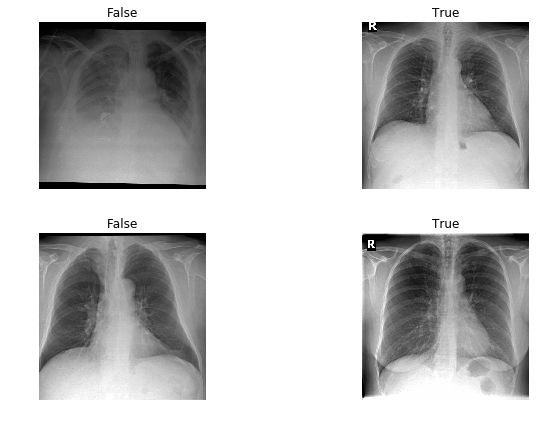

In [18]:
data.show_batch(rows=2, figsize=(10,6))


In [19]:
data.classes #[Abnormal, Normal]

[False, True]

True
ImageID    216840111366964013451228379692012290113138655_...
labels                                              [normal]
Normal                                                  True
Name: 56226, dtype: object


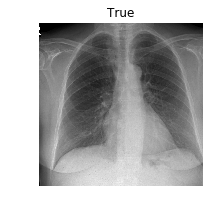

In [20]:
#show one study example from validation set
img,labels = data.valid_ds[-5]
print(labels)
print(df_fastai_normal.loc[val.index.values[-5],])
img.show(title=labels)


In [21]:
class AverageMetric(Callback):
    def __init__(self, func):
        self.func, self.name = func, func.__name__

    def on_epoch_begin(self, **kwargs):
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        self.count += last_target.size(0)
        self.val += last_target.size(0) * self.func(last_output, last_target).detach().item()

    def on_epoch_end(self, **kwargs):
        self.metric = self.val/self.count

In [22]:
class Precision(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==0) * (last_target==0)).float().sum()
        self.total += (preds==0).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total
        
class Recall(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.correct, self.total = 0, 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        self.correct += ((preds==0) * (last_target==0)).float().sum()
        self.total += (last_target==0).float().sum()
    
    def on_epoch_end(self, **kwargs):
        self.metric = self.correct/self.total

In [23]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta = 1)
f_score1 = partial(fbeta, thresh=0.1, beta = 1)
#metrics = listify([acc_02,f_score,f2_w, f_score1])
try:
    del learn
    gc.collect()
except:
    pass
learn = create_cnn(data, 
                   models.resnet18,
                   metrics=[accuracy,  Precision(), Recall()]).to_fp16()#, f2_micro, f2_macro, f2_w])

#learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


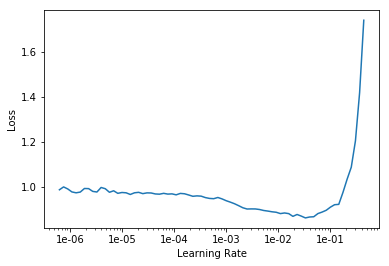

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall
1,0.459653,0.457615,0.777114,0.808288,0.875333


In [42]:
#import gc
#try:
#    del learn
#    gc.collect()
#except:
#    pass
#doc(create_cnn)
learn.save('stage-0')


In [28]:
learn.load('stage-0')


Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (85046 items)
[Category True, Category False, Category False, Category False, Category False]...
Path: /home/auri/SJ
x: MyImageItemList (85046 items)
[Image (3, 1024, 1109), Image (3, 1024, 1070), Image (3, 1133, 1024), Image (3, 1024, 1026), Image (3, 1024, 1245)]...
Path: /home/auri/SJ;

Valid: LabelList
y: CategoryList (21262 items)
[Category False, Category False, Category False, Category False, Category False]...
Path: /home/auri/SJ
x: MyImageItemList (21262 items)
[Image (3, 1024, 1024), Image (3, 1024, 1075), Image (3, 1024, 1024), Image (3, 1024, 1154), Image (3, 1024, 1156)]...
Path: /home/auri/SJ;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mo

In [ ]:
#learn.model
#learn.data.batch_size=16

In [29]:

learn.unfreeze()



In [30]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


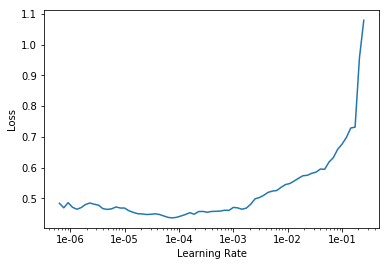

In [31]:
learn.recorder.plot()

In [ ]:
learn.loss_func.func

In [32]:
#learn.fit_one_cycle(20, max_lr=slice(1e-05,1e-4))
learn.fit_one_cycle(20, max_lr=1e-05)

epoch,train_loss,valid_loss,accuracy,precision,recall
1,0.463393,0.453724,0.779184,0.809191,0.877787
2,0.455033,0.447230,0.780877,0.813026,0.874422
3,0.474086,0.441644,0.786097,0.834735,0.849250
4,0.464831,0.437971,0.786662,0.832718,0.853387
5,0.449312,0.431578,0.790377,0.836965,0.853807
6,0.425844,0.428763,0.792494,0.835034,0.860679
7,0.412964,0.433342,0.788496,0.876765,0.796662
8,0.408635,0.421290,0.799219,0.834058,0.874702
9,0.395189,0.420512,0.798608,0.841968,0.861450
10,0.372391,0.419554,0.796727,0.858379,0.834666


In [33]:
learn.save('normal-20epochs')

In [34]:
learn.load('normal-20epochs')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (85046 items)
[Category True, Category False, Category False, Category False, Category False]...
Path: /home/auri/SJ
x: MyImageItemList (85046 items)
[Image (3, 1024, 1109), Image (3, 1024, 1070), Image (3, 1133, 1024), Image (3, 1024, 1026), Image (3, 1024, 1245)]...
Path: /home/auri/SJ;

Valid: LabelList
y: CategoryList (21262 items)
[Category False, Category False, Category False, Category False, Category False]...
Path: /home/auri/SJ
x: MyImageItemList (21262 items)
[Image (3, 1024, 1024), Image (3, 1024, 1075), Image (3, 1024, 1024), Image (3, 1024, 1154), Image (3, 1024, 1156)]...
Path: /home/auri/SJ;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mo

In [35]:

learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


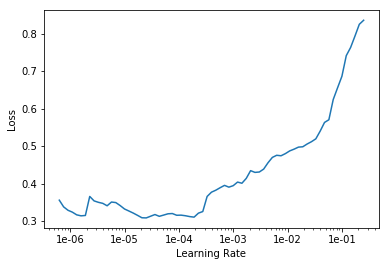

In [36]:
learn.recorder.plot()

In [ ]:
learn.save('stage-1')


In [ ]:
learn.load('stage-1')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-5,1e-4))

In [ ]:
learn.save('stage-3')


In [ ]:

learn.load('stage-3')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [37]:
probs = learn.get_preds()


In [38]:
print(probs[0][117],probs[1][117] )

tensor([9.9905e-01, 9.5287e-04]) tensor(0)


In [39]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

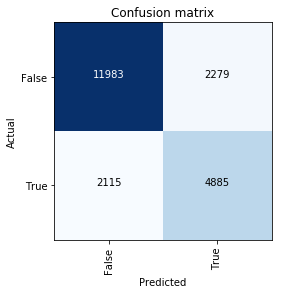

In [40]:
interp.plot_confusion_matrix()

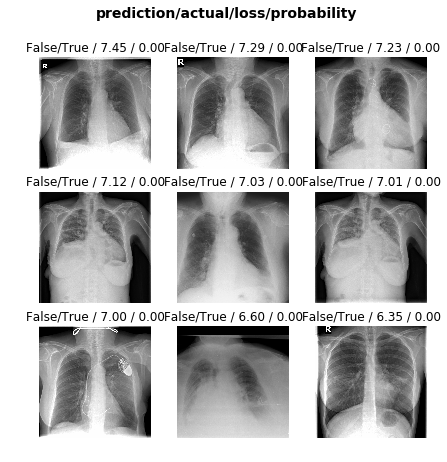

In [41]:
interp.plot_top_losses(9, figsize=(7,7))

In [42]:
interp.top_losses()[1][:45]

tensor([ 8780,  7708,  5695,  3309,  4225,  1070,  7638,  2960, 20818, 11667,
        11778,  7330,  8652, 18855, 11117, 16862,  1939,  9668, 11536, 10079,
        16335, 14031, 18318,   272, 17050, 14992,  7363,  7020, 13192,  2923,
        14760,  9761, 16617, 11126, 12518,  3425,  1828, 15993,  8310, 20862,
         1450, 12454, 10017,  1274,  2981])

True
ImageID    24261101740309413816287722892043693576_o31ijg.png
labels                                              [normal]
Normal                                                  True
Name: 25501, dtype: object
tensor([0.9986, 0.0014])
tensor(0)


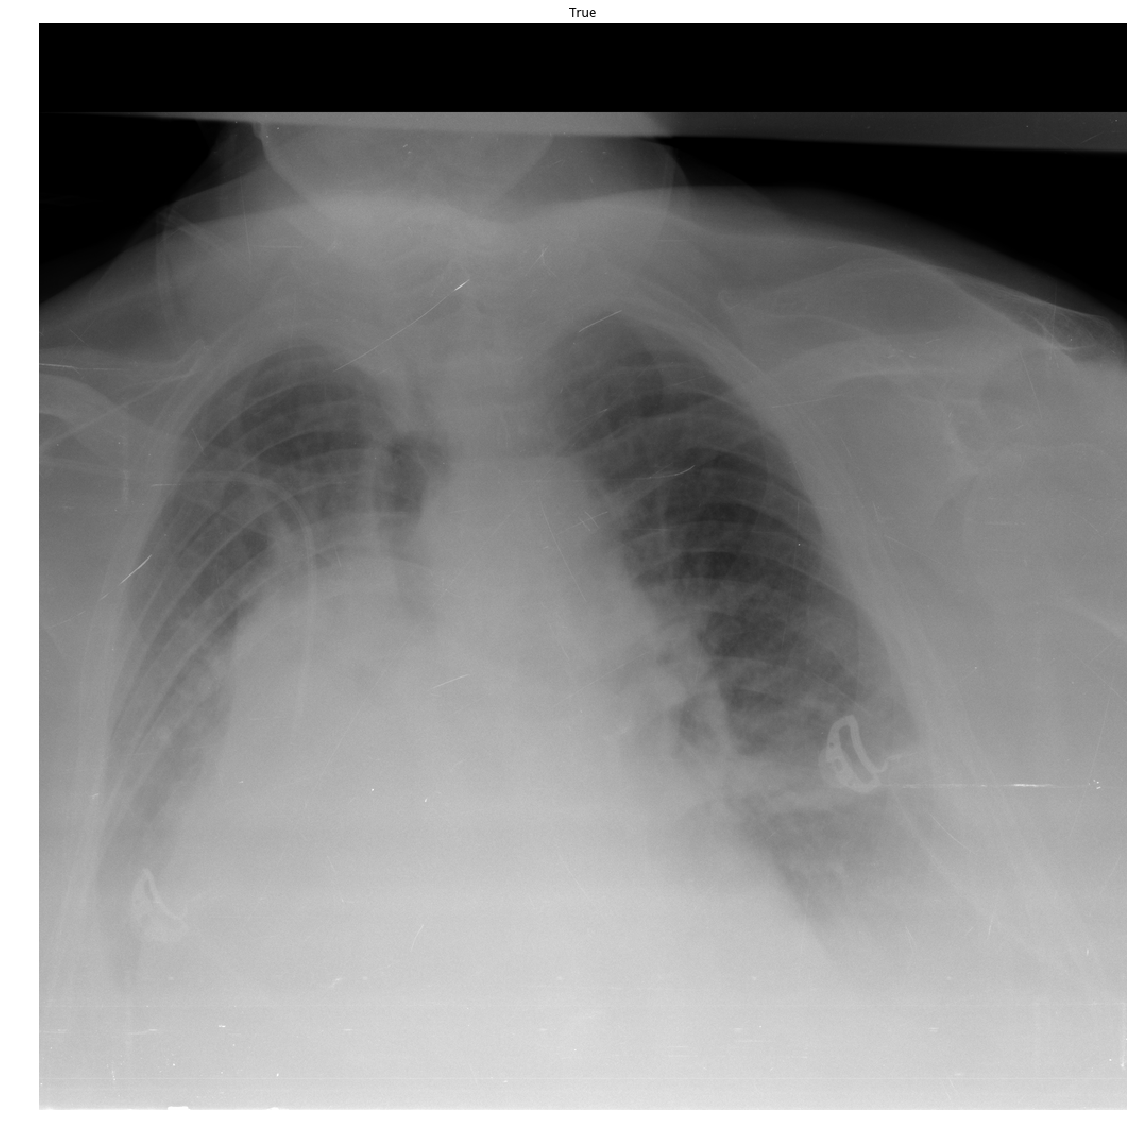

In [49]:
#Abnormal = 0, Normal= 1 
item = 2960
img,labels = data.valid_ds[item]
print(labels)
print(df_fastai_normal.loc[val.index.values[item],])
print(probs[0][item] )
print(np.argmax(probs[0][item], axis=0))
img.show(title=labels, figsize=(20,20) )